# Neural Ordinary Differential Equations (Neural ODEs)

## A Pedagogical Introduction

This notebook provides an illustrative introduction to Neural ODEs, a powerful framework that bridges continuous dynamical systems with deep learning.

**Key Concepts:**
- Neural ODEs model transformations as continuous flows rather than discrete layers
- They use ODE solvers to propagate hidden states through time
- Memory-efficient training via adjoint sensitivity method
- Adaptive computation based on problem complexity

**References:**
- Chen et al. (2018) "Neural Ordinary Differential Equations" - NeurIPS 2018 Best Paper

## 1. Mathematical Background

### Standard ResNet vs Neural ODE

**ResNet (Discrete):**
$$\mathbf{h}_{t+1} = \mathbf{h}_t + f(\mathbf{h}_t, \theta_t)$$

**Neural ODE (Continuous):**
$$\frac{d\mathbf{h}(t)}{dt} = f(\mathbf{h}(t), t, \theta)$$

The output is obtained by solving this ODE:
$$\mathbf{h}(T) = \mathbf{h}(0) + \int_0^T f(\mathbf{h}(t), t, \theta) dt$$

This can be thought of as taking the limit of infinitely many residual layers with infinitesimal step sizes.

In [1]:
# Install required packages if needed
# !pip install torchdiffeq scikit-learn matplotlib

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll, make_moons, make_circles
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torchdiffeq import odeint, odeint_adjoint
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 2. Building a Neural ODE from Scratch

### 2.1 ODE Function (Dynamics Network)

The core of a Neural ODE is the function $f$ that defines the dynamics. This is typically a neural network.

In [3]:
class ODEFunc(nn.Module):
    """Defines the dynamics dh/dt = f(h, t).
    
    This is a simple MLP that takes the current state and time
    and outputs the derivative (velocity) of the state.
    """
    def __init__(self, hidden_dim):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, hidden_dim)
        )
        # Track number of function evaluations
        self.nfe = 0
        
    def forward(self, t, h):
        """Forward pass: compute dh/dt.
        
        Args:
            t: Current time (scalar)
            h: Current state [batch_size, hidden_dim]
        Returns:
            dh/dt: Derivative of state
        """
        self.nfe += 1
        return self.net(h)

In [4]:
class NeuralODE(nn.Module):
    """Neural ODE model for classification/regression.
    
    Architecture:
    1. Input layer: Maps input to hidden dimension
    2. ODE Block: Evolves hidden state through continuous dynamics
    3. Output layer: Maps final hidden state to output
    """
    def __init__(self, input_dim, hidden_dim, output_dim, tol=1e-3):
        super(NeuralODE, self).__init__()
        
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.ode_func = ODEFunc(hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        
        # Integration time span [0, 1]
        self.integration_time = torch.tensor([0.0, 1.0])
        self.tol = tol
        
    def forward(self, x, return_trajectory=False):
        """Forward pass through the Neural ODE.
        
        Args:
            x: Input tensor [batch_size, input_dim]
            return_trajectory: If True, return intermediate states
        Returns:
            Output predictions and optionally the trajectory
        """
        # Map input to hidden space
        h0 = self.input_layer(x)
        
        # Move integration time to same device as input
        t = self.integration_time.to(x.device)
        
        # Reset NFE counter
        self.ode_func.nfe = 0
        
        if return_trajectory:
            # Get intermediate states for visualization
            t_span = torch.linspace(0, 1, 20).to(x.device)
            trajectory = odeint(
                self.ode_func, h0, t_span,
                rtol=self.tol, atol=self.tol,
                method='dopri5'
            )
            hT = trajectory[-1]
            out = self.output_layer(hT)
            return out, trajectory
        else:
            # Just compute final state
            hT = odeint(
                self.ode_func, h0, t,
                rtol=self.tol, atol=self.tol,
                method='dopri5'
            )[-1]
            out = self.output_layer(hT)
            return out
    
    @property
    def nfe(self):
        """Number of function evaluations (computational cost)."""
        return self.ode_func.nfe

## 3. Example 1: Learning Spiral Dynamics (Regression)

The Swiss Roll / Spiral is a classic example that demonstrates how Neural ODEs can **learn continuous dynamics**. 

**Task**: Given initial positions on a spiral, predict where points will move over time by learning the underlying differential equation that generates the spiral motion.

This is a natural fit for Neural ODEs because:
- The spiral has an underlying continuous dynamics
- We're learning $\frac{d\mathbf{x}}{dt} = f(\mathbf{x}, t)$ directly
- The model can interpolate and extrapolate trajectories

In [5]:
def generate_spiral_trajectories(n_trajectories=100, n_steps=50, noise=0.01):
    """Generate spiral trajectories for regression task.
    
    The true dynamics follow:
    dx/dt = -y
    dy/dt = x
    
    This creates circular/spiral motion.
    """
    trajectories = []
    
    # Generate different starting points
    for _ in range(n_trajectories):
        # Random starting point
        r = np.random.uniform(0.5, 2.0)
        theta = np.random.uniform(0, 2*np.pi)
        x0 = r * np.cos(theta)
        y0 = r * np.sin(theta)
        
        # Generate trajectory using Euler method (ground truth)
        dt = 0.1
        traj = [(x0, y0)]
        x, y = x0, y0
        
        for _ in range(n_steps - 1):
            # True dynamics: circular motion
            dx = -y * dt
            dy = x * dt
            x = x + dx
            y = y + dy
            traj.append((x + noise * np.random.randn(), 
                        y + noise * np.random.randn()))
        
        trajectories.append(np.array(traj))
    
    return np.array(trajectories)

# Generate spiral trajectories
n_traj = 200
n_steps = 30
trajectories = generate_spiral_trajectories(n_traj, n_steps, noise=0.02)

print(f"Generated {n_traj} trajectories")
print(f"Each trajectory has {n_steps} time steps")
print(f"Data shape: {trajectories.shape}")

# Create training data: predict future positions from initial position
# Input: initial position (x0, y0)
# Output: position after integration time T
X_spiral = trajectories[:, 0, :]  # Initial positions
y_spiral = trajectories[:, -1, :]  # Final positions

# Split data
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_spiral, y_spiral, test_size=0.3, random_state=42
)

# Convert to tensors
X_train_s_t = torch.FloatTensor(X_train_s).to(device)
y_train_s_t = torch.FloatTensor(y_train_s).to(device)
X_test_s_t = torch.FloatTensor(X_test_s).to(device)
y_test_s_t = torch.FloatTensor(y_test_s).to(device)

# Also keep full trajectories for visualization
traj_train = trajectories[:int(0.7 * n_traj)]
traj_test = trajectories[int(0.7 * n_traj):]

print(f"\nTraining samples: {len(X_train_s)}")
print(f"Test samples: {len(X_test_s)}")

Generated 200 trajectories
Each trajectory has 30 time steps
Data shape: (200, 30, 2)

Training samples: 140
Test samples: 60


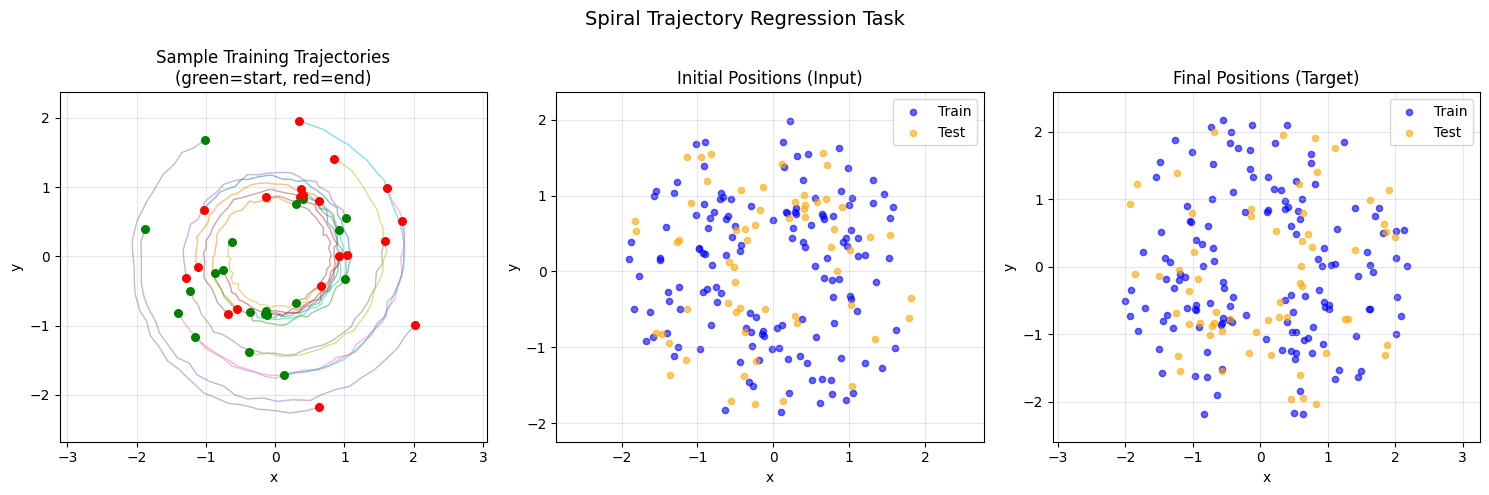

In [6]:
# Visualize the spiral trajectories
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot some sample trajectories
ax = axes[0]
for i in range(min(20, len(traj_train))):
    ax.plot(traj_train[i, :, 0], traj_train[i, :, 1], alpha=0.5, linewidth=1)
    ax.scatter(traj_train[i, 0, 0], traj_train[i, 0, 1], c='green', s=30, zorder=5)
    ax.scatter(traj_train[i, -1, 0], traj_train[i, -1, 1], c='red', s=30, zorder=5)
ax.set_title('Sample Training Trajectories\n(green=start, red=end)')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.grid(True, alpha=0.3)
ax.axis('equal')

# Plot initial positions
ax = axes[1]
ax.scatter(X_train_s[:, 0], X_train_s[:, 1], c='blue', alpha=0.6, s=20, label='Train')
ax.scatter(X_test_s[:, 0], X_test_s[:, 1], c='orange', alpha=0.6, s=20, label='Test')
ax.set_title('Initial Positions (Input)')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axis('equal')

# Plot final positions
ax = axes[2]
ax.scatter(y_train_s[:, 0], y_train_s[:, 1], c='blue', alpha=0.6, s=20, label='Train')
ax.scatter(y_test_s[:, 0], y_test_s[:, 1], c='orange', alpha=0.6, s=20, label='Test')
ax.set_title('Final Positions (Target)')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axis('equal')

plt.suptitle('Spiral Trajectory Regression Task', fontsize=14)
plt.tight_layout()
plt.show()

### 3.1 Training the Neural ODE for Regression

We train the Neural ODE to predict the final position given the initial position. The network learns the underlying dynamics by solving:

$$\mathbf{x}(T) = \mathbf{x}(0) + \int_0^T f(\mathbf{x}(t), t, \theta) dt$$

In [7]:
def train_regression_model(model, X_train, y_train, X_test, y_test, 
                            epochs=200, lr=0.01, batch_size=32):
    """Train the Neural ODE model for regression."""
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
    
    train_losses = []
    test_losses = []
    nfes = []  # Track computational cost
    
    n_batches = max(1, len(X_train) // batch_size)
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        
        # Shuffle data
        perm = torch.randperm(len(X_train))
        X_train_shuffled = X_train[perm]
        y_train_shuffled = y_train[perm]
        
        for i in range(n_batches):
            start = i * batch_size
            end = start + batch_size
            
            X_batch = X_train_shuffled[start:end]
            y_batch = y_train_shuffled[start:end]
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        scheduler.step()
        
        # Evaluate
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test).item()
        
        train_losses.append(epoch_loss / n_batches)
        test_losses.append(test_loss)
        nfes.append(model.nfe)
        
        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_losses[-1]:.6f} | "
                  f"Test Loss: {test_loss:.6f} | NFE: {model.nfe}")
    
    return train_losses, test_losses, nfes

In [8]:
# Create and train Neural ODE model for regression
model_spiral = NeuralODE(
    input_dim=2,   # (x, y) position
    hidden_dim=32, 
    output_dim=2,  # (x, y) predicted final position
    tol=1e-3
).to(device)

print("Training Neural ODE on Spiral Dynamics...")
print(f"Model parameters: {sum(p.numel() for p in model_spiral.parameters())}")

losses_train, losses_test, nfes_spiral = train_regression_model(
    model_spiral, X_train_s_t, y_train_s_t, X_test_s_t, y_test_s_t,
    epochs=300, lr=0.01, batch_size=32
)

Training Neural ODE on Spiral Dynamics...
Model parameters: 8514
Epoch 50/300 | Train Loss: 0.000442 | Test Loss: 0.000582 | NFE: 26
Epoch 100/300 | Train Loss: 0.000400 | Test Loss: 0.000522 | NFE: 26
Epoch 150/300 | Train Loss: 0.000387 | Test Loss: 0.000474 | NFE: 26
Epoch 200/300 | Train Loss: 0.000404 | Test Loss: 0.000497 | NFE: 26
Epoch 250/300 | Train Loss: 0.000374 | Test Loss: 0.000501 | NFE: 26
Epoch 300/300 | Train Loss: 0.000385 | Test Loss: 0.000480 | NFE: 26


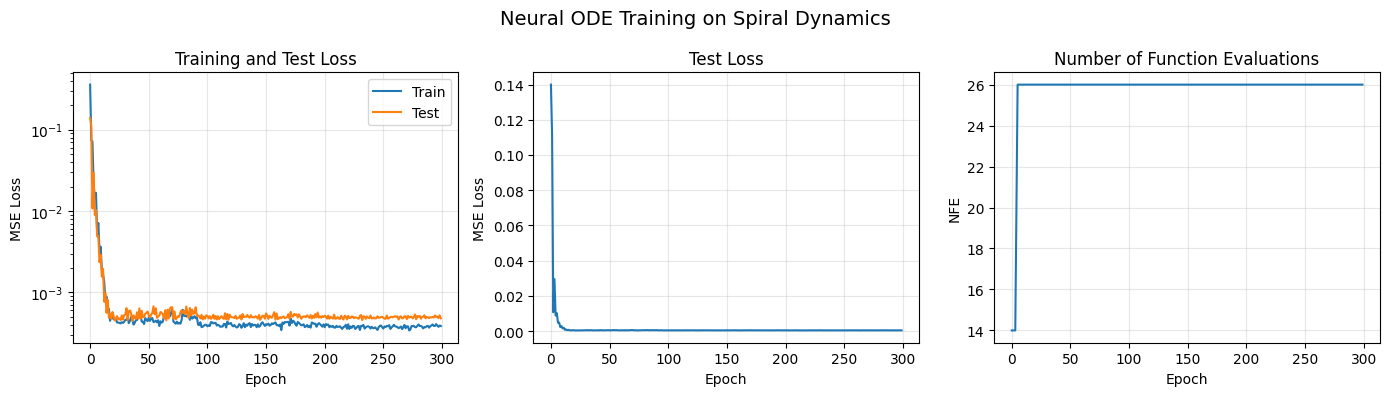


Final Test MSE: 0.000480
Final Test RMSE: 0.021905


In [9]:
# Plot training curves
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

axes[0].plot(losses_train, label='Train')
axes[0].plot(losses_test, label='Test')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE Loss')
axes[0].set_title('Training and Test Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_yscale('log')

axes[1].plot(losses_test)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MSE Loss')
axes[1].set_title('Test Loss')
axes[1].grid(True, alpha=0.3)

axes[2].plot(nfes_spiral)
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('NFE')
axes[2].set_title('Number of Function Evaluations')
axes[2].grid(True, alpha=0.3)

plt.suptitle('Neural ODE Training on Spiral Dynamics', fontsize=14)
plt.tight_layout()
plt.show()

print(f"\nFinal Test MSE: {losses_test[-1]:.6f}")
print(f"Final Test RMSE: {np.sqrt(losses_test[-1]):.6f}")

### 3.2 Visualizing Predictions

Let's see how well the Neural ODE predicts the final positions and compares to the ground truth.

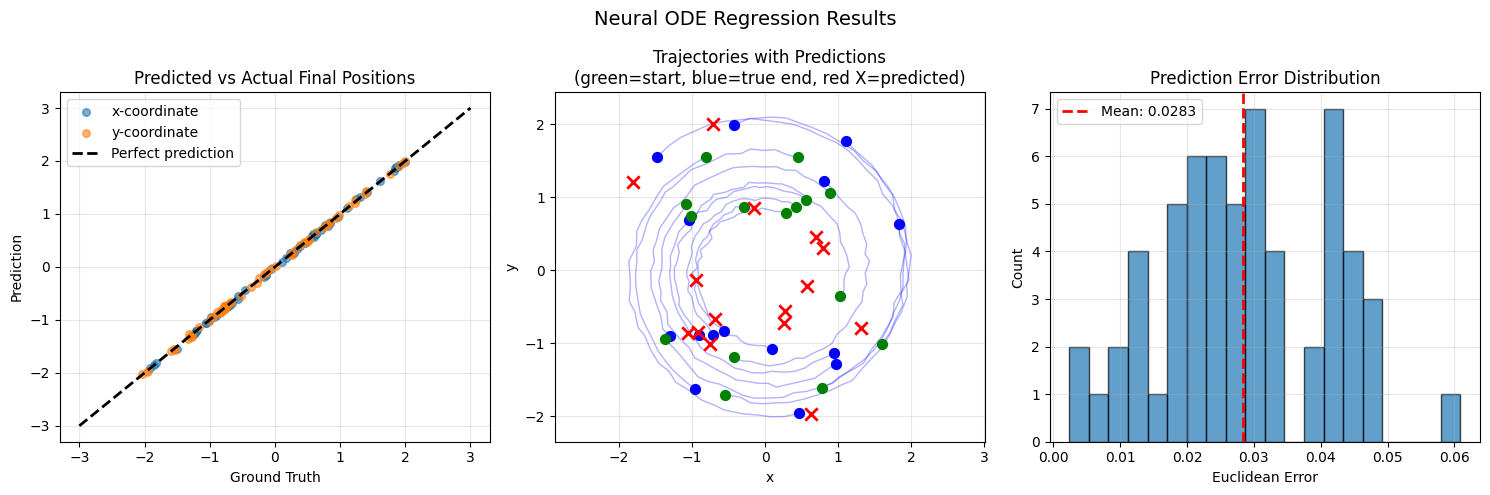

Mean Euclidean Error: 0.028334
Max Euclidean Error: 0.060903
Min Euclidean Error: 0.002400


In [10]:
# Visualize predictions vs ground truth
model_spiral.eval()
with torch.no_grad():
    predictions = model_spiral(X_test_s_t).cpu().numpy()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Predicted vs Actual (scatter)
ax = axes[0]
ax.scatter(y_test_s[:, 0], predictions[:, 0], alpha=0.6, s=30, label='x-coordinate')
ax.scatter(y_test_s[:, 1], predictions[:, 1], alpha=0.6, s=30, label='y-coordinate')
ax.plot([-3, 3], [-3, 3], 'k--', linewidth=2, label='Perfect prediction')
ax.set_xlabel('Ground Truth')
ax.set_ylabel('Prediction')
ax.set_title('Predicted vs Actual Final Positions')
ax.legend()
ax.grid(True, alpha=0.3)

# Show trajectories with predictions
ax = axes[1]
for i in range(min(15, len(traj_test))):
    # Ground truth trajectory
    ax.plot(traj_test[i, :, 0], traj_test[i, :, 1], 'b-', alpha=0.3, linewidth=1)
    ax.scatter(traj_test[i, 0, 0], traj_test[i, 0, 1], c='green', s=50, zorder=5)
    ax.scatter(traj_test[i, -1, 0], traj_test[i, -1, 1], c='blue', s=50, marker='o', zorder=5)
    # Predicted final position
    ax.scatter(predictions[i, 0], predictions[i, 1], c='red', s=80, marker='x', linewidths=2, zorder=6)

ax.set_title('Trajectories with Predictions\n(green=start, blue=true end, red X=predicted)')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.grid(True, alpha=0.3)
ax.axis('equal')

# Error distribution
ax = axes[2]
errors = np.sqrt(np.sum((predictions - y_test_s)**2, axis=1))
ax.hist(errors, bins=20, edgecolor='black', alpha=0.7)
ax.axvline(np.mean(errors), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(errors):.4f}')
ax.set_xlabel('Euclidean Error')
ax.set_ylabel('Count')
ax.set_title('Prediction Error Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

plt.suptitle('Neural ODE Regression Results', fontsize=14)
plt.tight_layout()
plt.show()

print(f"Mean Euclidean Error: {np.mean(errors):.6f}")
print(f"Max Euclidean Error: {np.max(errors):.6f}")
print(f"Min Euclidean Error: {np.min(errors):.6f}")

### 3.3 Extrapolation: Predicting Further into the Future

A key advantage of Neural ODEs is their ability to extrapolate. Let's see if the model can predict positions at different time horizons.

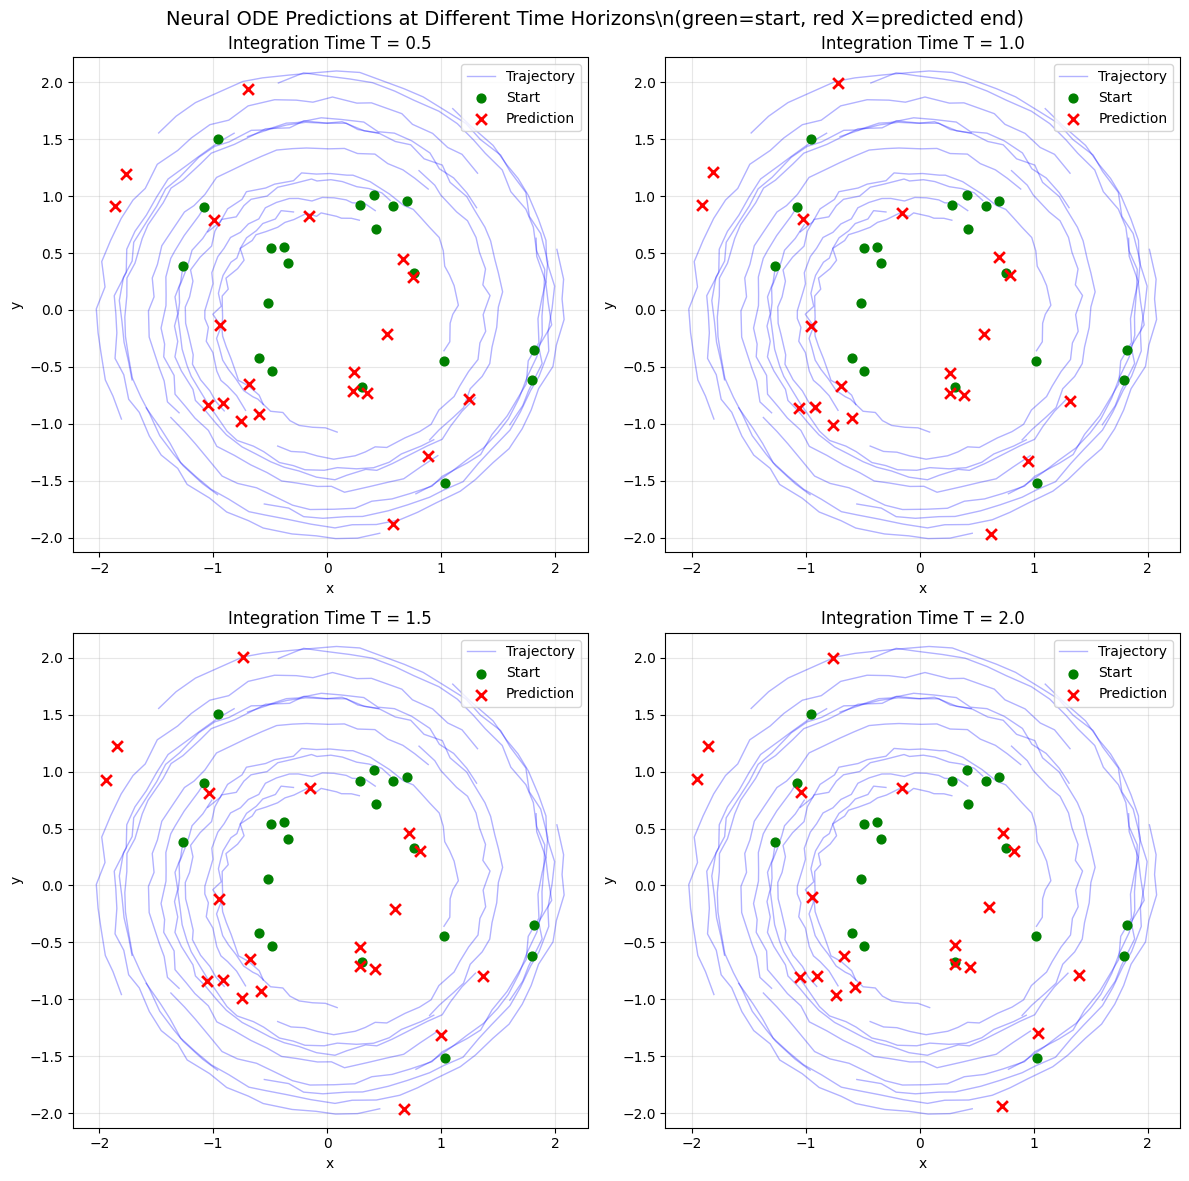

In [11]:
def test_extrapolation(model, X_test, trajectories_test, integration_times=[0.5, 1.0, 1.5, 2.0]):
    """Test the model's ability to predict at different time horizons."""
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    axes = axes.flatten()
    
    X_test_t = torch.FloatTensor(X_test).to(device)
    
    for idx, T in enumerate(integration_times):
        ax = axes[idx]
        
        # Modify model's integration time
        original_time = model.integration_time.clone()
        model.integration_time = torch.tensor([0.0, T])
        
        model.eval()
        with torch.no_grad():
            predictions = model(X_test_t).cpu().numpy()
        
        # Restore original time
        model.integration_time = original_time
        
        # Plot trajectories and predictions
        n_show = min(20, len(trajectories_test))
        for i in range(n_show):
            # True trajectory (as much as we have)
            ax.plot(trajectories_test[i, :, 0], trajectories_test[i, :, 1], 
                   'b-', alpha=0.3, linewidth=1)
            # Start point
            ax.scatter(X_test[i, 0], X_test[i, 1], c='green', s=40, zorder=5)
            # Predicted end point
            ax.scatter(predictions[i, 0], predictions[i, 1], c='red', s=60, 
                      marker='x', linewidths=2, zorder=6)
        
        ax.set_title(f'Integration Time T = {T:.1f}')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.grid(True, alpha=0.3)
        ax.axis('equal')
        ax.legend(['Trajectory', 'Start', 'Prediction'], loc='upper right')
    
    plt.suptitle('Neural ODE Predictions at Different Time Horizons\\n(green=start, red X=predicted end)', fontsize=14)
    plt.tight_layout()
    plt.show()

# Test extrapolation capabilities
test_extrapolation(model_spiral, X_test_s, traj_test, integration_times=[0.5, 1.0, 1.5, 2.0])

## 4. Example 2: Comparison with Standard MLP

Let's compare Neural ODE with a standard MLP on a more challenging dataset.

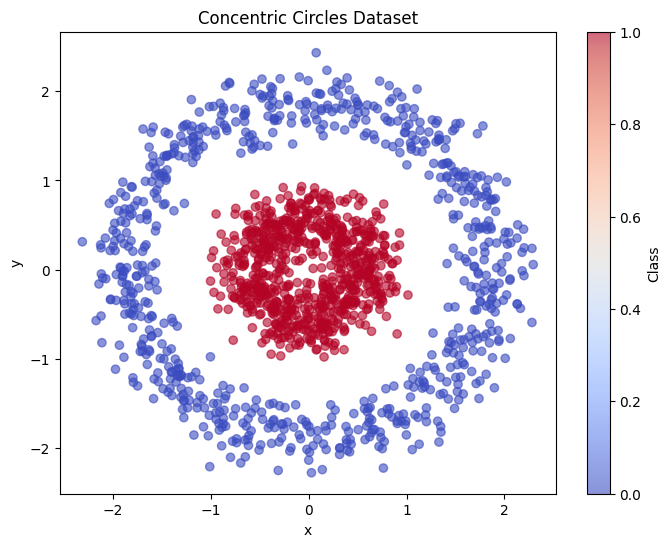

In [12]:
# Generate concentric circles dataset
X_circles, y_circles = make_circles(n_samples=1500, noise=0.1, factor=0.3, random_state=42)

# Standardize
scaler_circles = StandardScaler()
X_circles = scaler_circles.fit_transform(X_circles)

# Split
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_circles, y_circles, test_size=0.3, random_state=42
)

# Convert to tensors
X_train_c_t = torch.FloatTensor(X_train_c).to(device)
y_train_c_t = torch.LongTensor(y_train_c).to(device)
X_test_c_t = torch.FloatTensor(X_test_c).to(device)
y_test_c_t = torch.LongTensor(y_test_c).to(device)

# Visualize
plt.figure(figsize=(8, 6))
plt.scatter(X_circles[:, 0], X_circles[:, 1], c=y_circles, cmap='coolwarm', alpha=0.6)
plt.title('Concentric Circles Dataset')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar(label='Class')
plt.show()

In [13]:
class StandardMLP(nn.Module):
    """Standard Multi-Layer Perceptron for comparison."""
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers=3):
        super(StandardMLP, self).__init__()
        
        layers = [nn.Linear(input_dim, hidden_dim), nn.Tanh()]
        for _ in range(n_layers - 1):
            layers.extend([nn.Linear(hidden_dim, hidden_dim), nn.Tanh()])
        layers.append(nn.Linear(hidden_dim, output_dim))
        
        self.net = nn.Sequential(*layers)
        self.nfe = n_layers  # Fixed number of "evaluations"
    
    def forward(self, x):
        return self.net(x)

# Create models with similar capacity
model_node_circles = NeuralODE(2, 16, 2, tol=1e-3).to(device)
model_mlp_circles = StandardMLP(2, 16, 2, n_layers=3).to(device)

print(f"Neural ODE parameters: {sum(p.numel() for p in model_node_circles.parameters())}")
print(f"Standard MLP parameters: {sum(p.numel() for p in model_mlp_circles.parameters())}")

Neural ODE parameters: 6370
Standard MLP parameters: 626


In [14]:
# Training functions for classification
def train_model(model, X_train, y_train, X_test, y_test, 
                epochs=100, lr=0.01, batch_size=64):
    """Train the Neural ODE model for classification."""
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
    
    train_losses = []
    test_accs = []
    nfes = []  # Track computational cost
    
    n_batches = len(X_train) // batch_size
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        
        # Shuffle data
        perm = torch.randperm(len(X_train))
        X_train_shuffled = X_train[perm]
        y_train_shuffled = y_train[perm]
        
        for i in range(n_batches):
            start = i * batch_size
            end = start + batch_size
            
            X_batch = X_train_shuffled[start:end]
            y_batch = y_train_shuffled[start:end]
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        scheduler.step()
        
        # Evaluate
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            _, predicted = torch.max(test_outputs, 1)
            accuracy = (predicted == y_test).float().mean().item()
        
        train_losses.append(epoch_loss / n_batches)
        test_accs.append(accuracy)
        nfes.append(model.nfe)
        
        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1}/{epochs} | Loss: {train_losses[-1]:.4f} | "
                  f"Test Acc: {accuracy:.4f} | NFE: {model.nfe}")
    
    return train_losses, test_accs, nfes

def train_mlp(model, X_train, y_train, X_test, y_test, epochs=100, lr=0.01, batch_size=64):
    """Train standard MLP."""
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
    
    train_losses = []
    test_accs = []
    
    n_batches = len(X_train) // batch_size
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        
        perm = torch.randperm(len(X_train))
        X_train_shuffled = X_train[perm]
        y_train_shuffled = y_train[perm]
        
        for i in range(n_batches):
            start = i * batch_size
            end = start + batch_size
            
            X_batch = X_train_shuffled[start:end]
            y_batch = y_train_shuffled[start:end]
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        scheduler.step()
        
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            _, predicted = torch.max(test_outputs, 1)
            accuracy = (predicted == y_test).float().mean().item()
        
        train_losses.append(epoch_loss / n_batches)
        test_accs.append(accuracy)
        
        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1}/{epochs} | Loss: {train_losses[-1]:.4f} | Test Acc: {accuracy:.4f}")
    
    return train_losses, test_accs

print("Training Neural ODE...")
losses_node_c, accs_node_c, _ = train_model(
    model_node_circles, X_train_c_t, y_train_c_t, X_test_c_t, y_test_c_t,
    epochs=100, lr=0.01
)

print("\nTraining Standard MLP...")
losses_mlp_c, accs_mlp_c = train_mlp(
    model_mlp_circles, X_train_c_t, y_train_c_t, X_test_c_t, y_test_c_t,
    epochs=100, lr=0.01
)

Training Neural ODE...
Epoch 20/100 | Loss: 0.0014 | Test Acc: 1.0000 | NFE: 20
Epoch 40/100 | Loss: 0.0000 | Test Acc: 1.0000 | NFE: 26
Epoch 60/100 | Loss: 0.0000 | Test Acc: 1.0000 | NFE: 26
Epoch 80/100 | Loss: 0.0000 | Test Acc: 1.0000 | NFE: 26
Epoch 100/100 | Loss: 0.0000 | Test Acc: 1.0000 | NFE: 26

Training Standard MLP...
Epoch 20/100 | Loss: 0.0005 | Test Acc: 1.0000
Epoch 40/100 | Loss: 0.0001 | Test Acc: 1.0000
Epoch 60/100 | Loss: 0.0001 | Test Acc: 1.0000
Epoch 80/100 | Loss: 0.0000 | Test Acc: 1.0000
Epoch 100/100 | Loss: 0.0000 | Test Acc: 1.0000


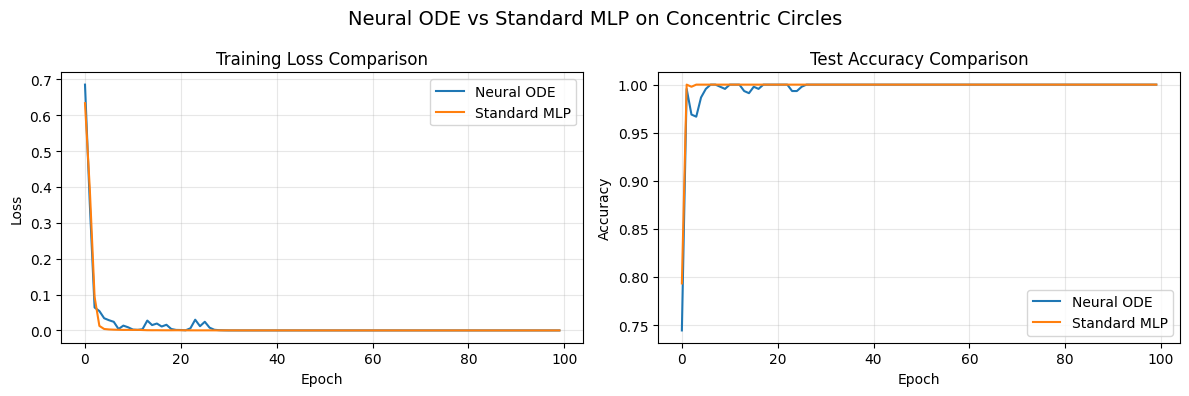

Final Neural ODE Accuracy: 1.0000
Final Standard MLP Accuracy: 1.0000


In [15]:
# Compare results
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(losses_node_c, label='Neural ODE')
axes[0].plot(losses_mlp_c, label='Standard MLP')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss Comparison')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(accs_node_c, label='Neural ODE')
axes[1].plot(accs_mlp_c, label='Standard MLP')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Test Accuracy Comparison')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('Neural ODE vs Standard MLP on Concentric Circles', fontsize=14)
plt.tight_layout()
plt.show()

print(f"Final Neural ODE Accuracy: {accs_node_c[-1]:.4f}")
print(f"Final Standard MLP Accuracy: {accs_mlp_c[-1]:.4f}")

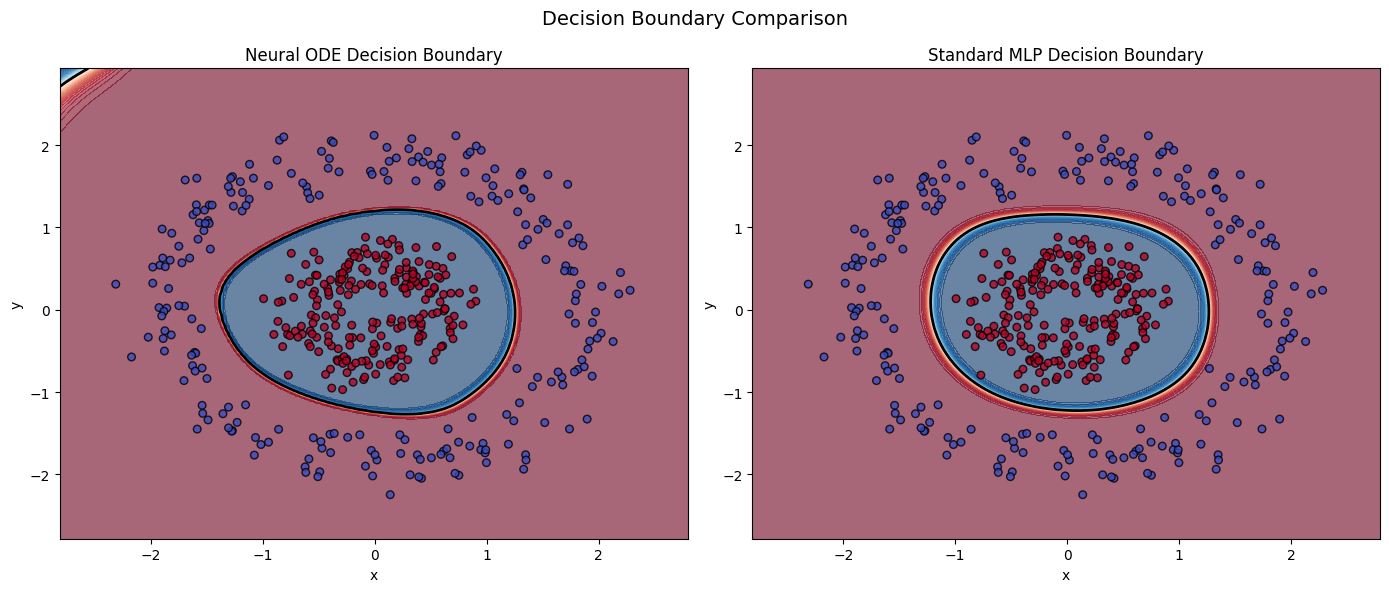

In [16]:
# Compare decision boundaries
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for ax, model, title in zip(
    axes, 
    [model_node_circles, model_mlp_circles],
    ['Neural ODE', 'Standard MLP']
):
    x_min, x_max = X_circles[:, 0].min() - 0.5, X_circles[:, 0].max() + 0.5
    y_min, y_max = X_circles[:, 1].min() - 0.5, X_circles[:, 1].max() + 0.5
    
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 200),
        np.linspace(y_min, y_max, 200)
    )
    
    grid = np.column_stack([xx.ravel(), yy.ravel()])
    grid_tensor = torch.FloatTensor(grid).to(device)
    
    model.eval()
    with torch.no_grad():
        Z = model(grid_tensor)
        Z = torch.softmax(Z, dim=1)[:, 1].cpu().numpy()
    
    Z = Z.reshape(xx.shape)
    
    ax.contourf(xx, yy, Z, levels=50, cmap='RdBu', alpha=0.6)
    ax.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2)
    ax.scatter(X_test_c[:, 0], X_test_c[:, 1], c=y_test_c, 
               cmap='coolwarm', edgecolors='black', s=30, alpha=0.8)
    ax.set_title(f'{title} Decision Boundary')
    ax.set_xlabel('x')
    ax.set_ylabel('y')

plt.suptitle('Decision Boundary Comparison', fontsize=14)
plt.tight_layout()
plt.show()

## 5. Example 3: Small Image Classification (MNIST Subset)

Let's apply Neural ODEs to a small subset of MNIST to demonstrate their applicability to real-world data.

In [17]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

# Load MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

mnist_train = datasets.MNIST('./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST('./data', train=False, transform=transform)

# Use only digits 0 and 1 for binary classification
def filter_dataset(dataset, labels=[0, 1]):
    indices = [i for i, (_, label) in enumerate(dataset) if label in labels]
    return Subset(dataset, indices)

mnist_train_filtered = filter_dataset(mnist_train, [0, 1])
mnist_test_filtered = filter_dataset(mnist_test, [0, 1])

# Use a smaller subset for faster training
train_subset_indices = np.random.choice(len(mnist_train_filtered), 2000, replace=False)
test_subset_indices = np.random.choice(len(mnist_test_filtered), 500, replace=False)

train_loader = DataLoader(Subset(mnist_train_filtered, train_subset_indices), batch_size=64, shuffle=True)
test_loader = DataLoader(Subset(mnist_test_filtered, test_subset_indices), batch_size=64, shuffle=False)

print(f"Training samples: {len(train_loader.dataset)}")
print(f"Test samples: {len(test_loader.dataset)}")

Training samples: 2000
Test samples: 500


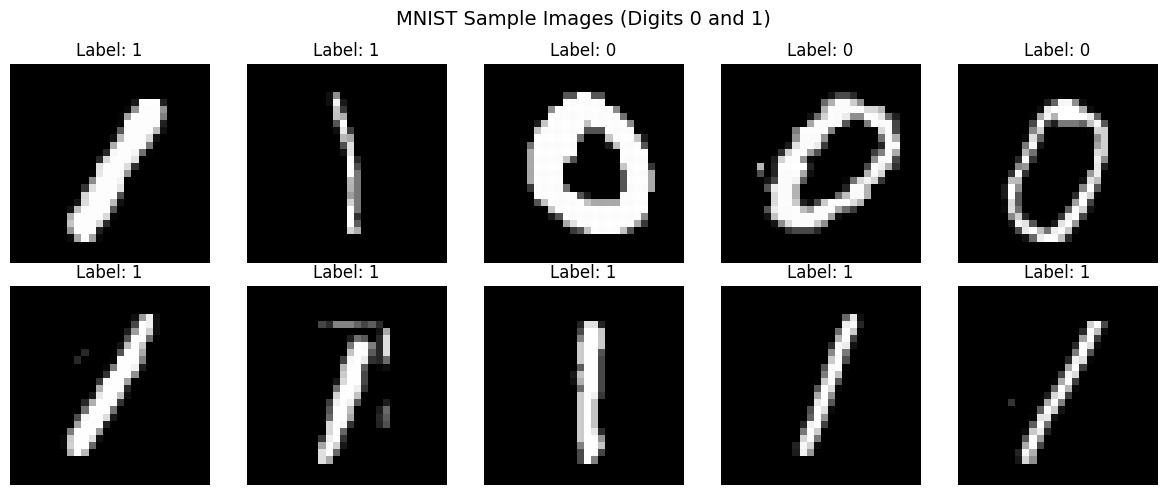

In [18]:
# Visualize some samples
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, (img, label) in enumerate(train_loader):
    if i >= 10:
        break
    ax = axes[i // 5, i % 5]
    ax.imshow(img[0].squeeze().cpu().numpy(), cmap='gray')
    ax.set_title(f'Label: {label[0].item()}')
    ax.axis('off')
plt.suptitle('MNIST Sample Images (Digits 0 and 1)', fontsize=14)
plt.tight_layout()
plt.show()

In [19]:
class ConvODEFunc(nn.Module):
    """Convolutional ODE function for image data."""
    def __init__(self, channels):
        super(ConvODEFunc, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1)
        self.norm1 = nn.GroupNorm(min(8, channels), channels)
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1)
        self.norm2 = nn.GroupNorm(min(8, channels), channels)
        self.nfe = 0
        
    def forward(self, t, x):
        self.nfe += 1
        out = self.conv1(x)
        out = self.norm1(out)
        out = torch.relu(out)
        out = self.conv2(out)
        out = self.norm2(out)
        return out

class ConvNeuralODE(nn.Module):
    """Neural ODE for image classification."""
    def __init__(self, in_channels=1, hidden_channels=16, num_classes=2):
        super(ConvNeuralODE, self).__init__()
        
        # Downsampling
        self.downsample = nn.Sequential(
            nn.Conv2d(in_channels, hidden_channels, 3, padding=1),
            nn.GroupNorm(min(8, hidden_channels), hidden_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_channels, hidden_channels, 4, stride=2, padding=1),  # 28->14
            nn.GroupNorm(min(8, hidden_channels), hidden_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_channels, hidden_channels, 4, stride=2, padding=1),  # 14->7
        )
        
        # ODE block
        self.ode_func = ConvODEFunc(hidden_channels)
        self.integration_time = torch.tensor([0.0, 1.0])
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(hidden_channels, num_classes)
        )
        
    def forward(self, x):
        # Downsample
        h = self.downsample(x)
        
        # ODE block
        self.ode_func.nfe = 0
        t = self.integration_time.to(x.device)
        h = odeint(self.ode_func, h, t, method='dopri5', rtol=1e-3, atol=1e-3)[-1]
        
        # Classify
        return self.classifier(h)
    
    @property
    def nfe(self):
        return self.ode_func.nfe

In [20]:
# Create and train the model
model_mnist = ConvNeuralODE(in_channels=1, hidden_channels=16, num_classes=2).to(device)
print(f"Model parameters: {sum(p.numel() for p in model_mnist.parameters())}")

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_mnist.parameters(), lr=0.001)

# Training loop
epochs = 20
train_losses = []
test_accs = []

for epoch in range(epochs):
    model_mnist.train()
    epoch_loss = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model_mnist(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    # Evaluate
    model_mnist.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model_mnist(data)
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    accuracy = correct / total
    train_losses.append(epoch_loss / len(train_loader))
    test_accs.append(accuracy)
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{epochs} | Loss: {train_losses[-1]:.4f} | "
              f"Test Acc: {accuracy:.4f} | NFE: {model_mnist.nfe}")

Model parameters: 13186
Epoch 5/20 | Loss: 0.0220 | Test Acc: 1.0000 | NFE: 20
Epoch 10/20 | Loss: 0.0120 | Test Acc: 0.9960 | NFE: 20
Epoch 15/20 | Loss: 0.0163 | Test Acc: 1.0000 | NFE: 20
Epoch 20/20 | Loss: 0.0048 | Test Acc: 0.9940 | NFE: 26


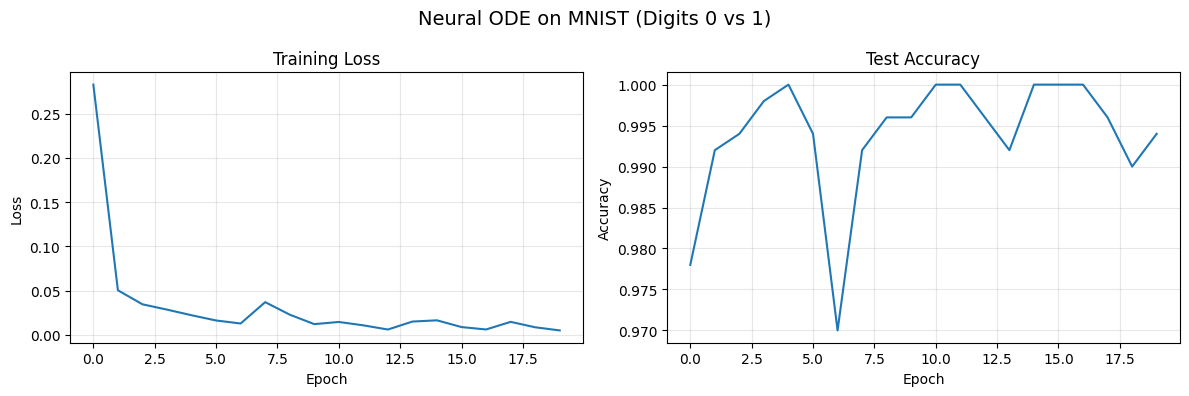

Final Test Accuracy: 0.9940


In [21]:
# Plot results
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(train_losses)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].grid(True, alpha=0.3)

axes[1].plot(test_accs)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Test Accuracy')
axes[1].grid(True, alpha=0.3)

plt.suptitle('Neural ODE on MNIST (Digits 0 vs 1)', fontsize=14)
plt.tight_layout()
plt.show()

print(f"Final Test Accuracy: {test_accs[-1]:.4f}")

### 5.1 Comparison with Standard CNN

Let's compare the Neural ODE with a standard CNN that has a similar architecture.

In [22]:
class StandardCNN(nn.Module):
    """Standard CNN for comparison with Neural ODE."""
    def __init__(self, in_channels=1, hidden_channels=16, num_classes=2):
        super(StandardCNN, self).__init__()
        
        # Similar architecture to ConvNeuralODE but with residual blocks instead of ODE
        self.features = nn.Sequential(
            # Downsampling (same as Neural ODE)
            nn.Conv2d(in_channels, hidden_channels, 3, padding=1),
            nn.GroupNorm(min(8, hidden_channels), hidden_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_channels, hidden_channels, 4, stride=2, padding=1),  # 28->14
            nn.GroupNorm(min(8, hidden_channels), hidden_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_channels, hidden_channels, 4, stride=2, padding=1),  # 14->7
            nn.GroupNorm(min(8, hidden_channels), hidden_channels),
            nn.ReLU(inplace=True),
            
            # Additional conv layers (instead of ODE block)
            nn.Conv2d(hidden_channels, hidden_channels, 3, padding=1),
            nn.GroupNorm(min(8, hidden_channels), hidden_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_channels, hidden_channels, 3, padding=1),
            nn.GroupNorm(min(8, hidden_channels), hidden_channels),
            nn.ReLU(inplace=True),
        )
        
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(hidden_channels, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

# Create Standard CNN
model_cnn = StandardCNN(in_channels=1, hidden_channels=16, num_classes=2).to(device)
print(f"Neural ODE parameters: {sum(p.numel() for p in model_mnist.parameters())}")
print(f"Standard CNN parameters: {sum(p.numel() for p in model_cnn.parameters())}")

# Train Standard CNN
criterion = nn.CrossEntropyLoss()
optimizer_cnn = torch.optim.Adam(model_cnn.parameters(), lr=0.001)

train_losses_cnn = []
test_accs_cnn = []

print("\nTraining Standard CNN...")
for epoch in range(epochs):
    model_cnn.train()
    epoch_loss = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer_cnn.zero_grad()
        output = model_cnn(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer_cnn.step()
        
        epoch_loss += loss.item()
    
    # Evaluate
    model_cnn.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model_cnn(data)
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    accuracy = correct / total
    train_losses_cnn.append(epoch_loss / len(train_loader))
    test_accs_cnn.append(accuracy)
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{epochs} | Loss: {train_losses_cnn[-1]:.4f} | Test Acc: {accuracy:.4f}")

Neural ODE parameters: 13186
Standard CNN parameters: 13218

Training Standard CNN...
Epoch 5/20 | Loss: 0.0998 | Test Acc: 0.9920
Epoch 10/20 | Loss: 0.0186 | Test Acc: 0.9980
Epoch 15/20 | Loss: 0.0116 | Test Acc: 0.9980
Epoch 20/20 | Loss: 0.0088 | Test Acc: 1.0000


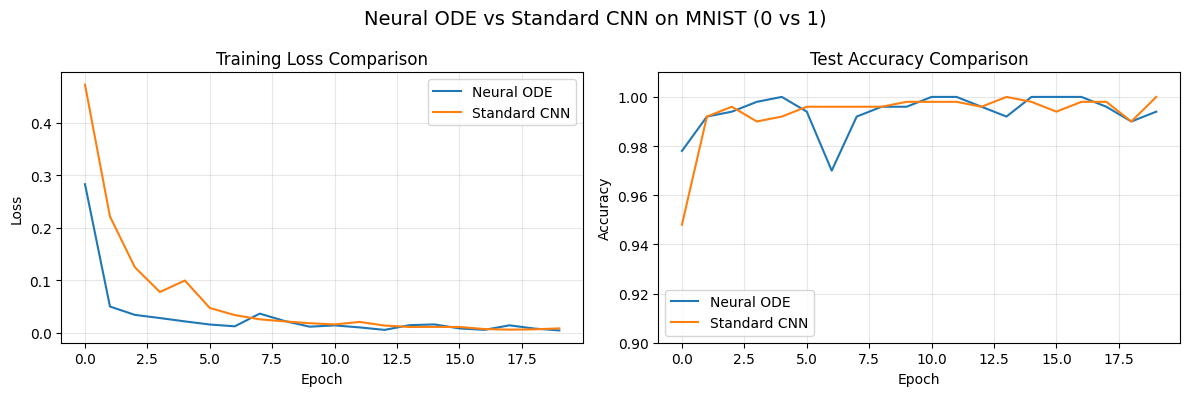


Final Neural ODE Test Accuracy: 0.9940
Final Standard CNN Test Accuracy: 1.0000

Neural ODE NFE (last epoch): 26
Standard CNN: Fixed depth (no adaptive computation)


In [23]:
# Compare Neural ODE vs Standard CNN on MNIST
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(train_losses, label='Neural ODE')
axes[0].plot(train_losses_cnn, label='Standard CNN')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss Comparison')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(test_accs, label='Neural ODE')
axes[1].plot(test_accs_cnn, label='Standard CNN')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Test Accuracy Comparison')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0.9, 1.01])

plt.suptitle('Neural ODE vs Standard CNN on MNIST (0 vs 1)', fontsize=14)
plt.tight_layout()
plt.show()

print(f"\nFinal Neural ODE Test Accuracy: {test_accs[-1]:.4f}")
print(f"Final Standard CNN Test Accuracy: {test_accs_cnn[-1]:.4f}")
print(f"\nNeural ODE NFE (last epoch): {model_mnist.nfe}")
print(f"Standard CNN: Fixed depth (no adaptive computation)")